In [1]:
import pytorch_lightning as pl
import Utilities as ut
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from model import Hitting_prob_model
import math
from Langevin import Langevin_Dyn
from model import Hitting_prob_model
from pytorch_lightning.callbacks import ModelCheckpoint
import numpy as np
from Data_Handler import Data_Handler

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
    
class B_ID(nn.Module):
    def __init__(self):
        '''
        Init method.
        '''
        super().__init__() # init the base class
    
    def forward(self, input):
        '''
        Forward pass of the function.
        '''
        return input + ((input**2+1)**(.5)-1)/2
    
class Sine_activation(nn.Module):
    def __init__(self):
        '''
        Init method.
        '''
        super().__init__() # init the base class
    
    def forward(self, input):
        '''
        Forward pass of the function.
        '''
        return torch.sin(input)

initial_state = torch.tensor([
    [-0.6, 1.5],
    ], device = device)

final_state = torch.tensor([
    [.6,-0],
    ], device = device)

mask = torch.tensor([
    [1., 1.],
    ])

mlp_args = {
    'hidden_layers': 5, 
    'width': 256, 
    'input_dim': 3, 
    'activation': Sine_activation(),#nn.SELU(), 
    'norm': False,
    'dropout': False
    }


boundary_args = {
    'reference' : final_state,
    'tolerance' : .2,
    'slope' : 0.001,
    'mask' : mask,
    'keyword': 'Indicator'
}

FBSDE_args = {
    'grad' : False,
    'alpha': 1,
    'beta': .01
    }

normalization_dict = {
    'ph_space_means': torch.tensor([0,0]),
    'time_mean': torch.tensor([0]),
    'ph_space_stds': torch.tensor([2, 2]),
    'time_std': torch.tensor([1])
}

model_args = {
    'mlp_args': mlp_args, 
    'boundary_args': boundary_args, 
    'FBSDE_args':  FBSDE_args,
    'normalization_dict': None,
    'initial_lr' : 5e-5
}

PATH = "./checkpoints_final__/epoch=425-step=120132.ckpt"

model = Hitting_prob_model.load_from_checkpoint(
    PATH,
    map_location=torch.device('cpu'),
    **model_args
    )

# disable randomness, dropout, etc...
model.eval()
model.freeze()

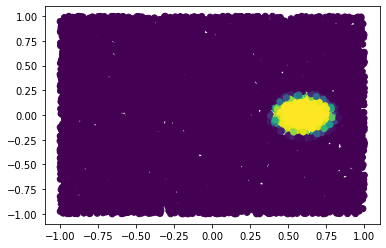

In [42]:
from Boundary_Conditions import Boundary_functions
from matplotlib import pyplot as plt

boundary_args = {
    'reference' : final_state,
    'tolerance' : .2,
    'slope' : .01,
    'mask' : mask,
    'keyword': 'Sigmoid' #alternatives 'Bump', 'Sigmoid', 'Indicator'
}


bf = Boundary_functions(**boundary_args)

set = 2*(torch.rand(size = (10000,2)) - 0.5)

color = bf.Sigmoid(set).numpy()

plt.scatter(set[:,0], set[:,1], c = color)

In [3]:
trajs = torch.load('./data/data_val/trajs.pt')

IndexError: index 1564 is out of bounds for dimension 0 with size 1564

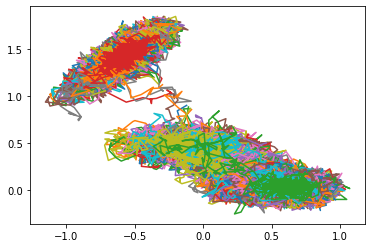

In [4]:
for i in range(0,3000):
    plt.plot(trajs[i, :, 0, 0].numpy(), trajs[i, :, 0, 1].numpy())

In [21]:
import torch
from Langevin import Langevin_Dyn
from Potentials import Mueller_Potential

N = 100
# Set up parameters for Langevin dynamics and potential
Time_duration = 10.0
dt = 0.01
temperature = torch.tensor([7.0])
num_particles = 10
initial_state = torch.rand(N, num_particles, 2)  # Set initial positions randomly
drag = 10.0
potential_args = {}  # No additional arguments for the potential

# Create Langevin dynamics object
langevin_sim = Langevin_Dyn(Time_duration, dt, temperature, initial_state, Mueller_Potential, drag, potential_args)

# Perform Langevin dynamics simulation
trajectories, time_axis, _, _, _ = langevin_sim.Dyn_run(initial_state)

# trajectories will contain the positions of N particles over time
# time_axis will contain the time points corresponding to each frame in trajectories


100%|██████████| 1000/1000 [00:11<00:00, 84.21it/s]


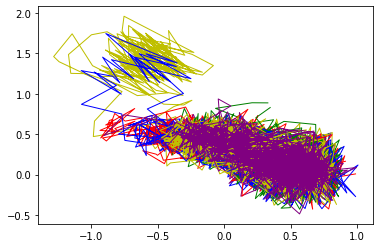

In [26]:
for i in range(0,10):
    plt.plot(trajectories[-10,:,i,0].detach().numpy(), trajectories[-10,:,i,1].detach().numpy())

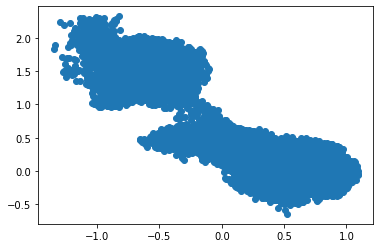

In [ ]:
X = trajs.view(-1, trajs.size(2), trajs.size(3))
plt.scatter(X[:, 0, 0].numpy(), X[:, 0, 1].numpy())

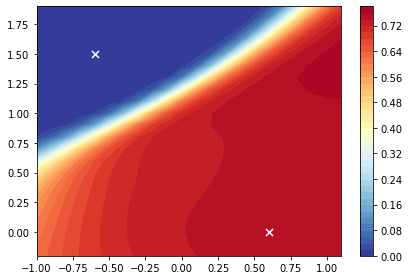

In [2]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import imageio

probs = []

for i in np.arange(-1.,1.2, 0.1):
    tmp = []
    for j in np.arange(-.2,2, 0.1):
        x = torch.tensor([[i,j],
                        ], device = device)
        x = x.view(1, x.size(0), -1)
        time = torch.tensor([.3]).view(1,-1)
        prob = model.model_step(x, time).item()
        #print(prob)
        tmp.append(prob)
    probs.append(tmp)

x = np.arange(-1.,1.2, 0.1)
y = np.arange(-.2,2, 0.1)
plt.clf()
plt.contourf(x, y, np.array(probs).T, 50, cmap = 'RdYlBu_r')
plt.colorbar()
plt.scatter(-.6,1.5, c = 'w', marker='x', s = 50)
plt.scatter(.6, 0., c = 'w', marker='x', s = 50)

plt.tight_layout()


  0%|          | 0/21 [00:00<?, ?it/s]

100%|██████████| 21/21 [00:00<00:00, 141.61it/s]


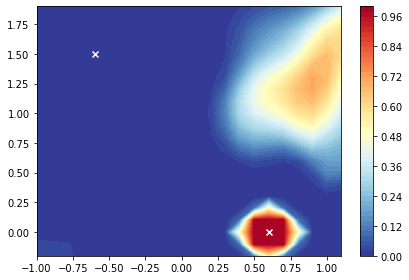

In [3]:

import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import imageio

def frame(t):
    probs = []
    for i in np.arange(-1.,1.2, 0.1):
        tmp = []
        for j in np.arange(-.2,2, 0.1):
            x = torch.tensor([[i,j],
                            ], device = device)
            x = x.view(1, x.size(0), -1)
            time = torch.tensor([t*5e-2]).view(1,-1)
            prob = model.model_step(x, time).item()
            
            #print(prob)
            tmp.append(prob)
        probs.append(tmp)
    
    x = np.arange(-1.,1.2, 0.1)
    y = np.arange(-.2,2, 0.1)
    plt.clf()
    plt.contourf(x, y, np.array(probs).T, 50, cmap = 'RdYlBu_r')
    plt.colorbar()
    plt.scatter(-.6,1.5, c = 'w', marker='x')
    plt.scatter(.6, 0., c = 'w', marker='x')
    plt.tight_layout()
    plt.savefig('./plots/frame_{}.png'.format(t))

for t in tqdm(range(0,21)):
    frame(t)
    
frames = []
for t in tqdm(range(0,21)):
    image = imageio.v2.imread(f'./plots/frame_{t}.png')
    frames.append(image)

imageio.mimsave(
    './plots/animation.gif', # output gif
    frames,          # array of input frames
    fps = 5
    )


In [4]:
from Langevin import Langevin_Dyn
from Potentials import Mueller_Potential
initial_state = torch.tensor([
    [-0.6, 1.5],
    ], device = device)

def potential(x):
    c_0 = torch.tensor([-2, -2, -2, -2, -2], device = device).view(1,initial_state.size(0),-1).repeat(x.size(0), 1, 1)
    c_1 = torch.tensor([2, 2, 2, 2, 2], device = device).view(1,initial_state.size(0),-1).repeat(x.size(0), 1, 1)
    potential = (torch.exp(-((x/3).norm(dim = 2))**2)*((((x-c_0)**2).sum(dim = 2))*(((x-c_1)**2).sum(dim = 2)))).sum(dim = 1)
    potential.view(-1,1)
    return potential

T = 7.

args = {
    'Time_duration':1,
    'dt' : 1/500,
    'temperature':torch.tensor([T], device = device),
    'initial_state':initial_state.view(1, 1, -1),
    'drag':10.,
    'potential':Mueller_Potential,
    'potential_args':{},
}

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:54<00:00,  9.23it/s]


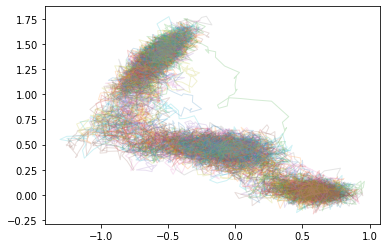

In [5]:
from matplotlib import pyplot as plt
from cycler import cycler
from scipy.stats import maxwell
from scipy.stats import qmc

dyn = Langevin_Dyn(**args)

n = 50

initial_state2 = initial_state.view(1, 1, -1).repeat(n,1,1)
trajsd, time, B = dyn.Dyn_run_driven(
    initial_state2,
    committor_model=model.model_step
)

trajsd = trajsd.detach().numpy()

for k in range(0,n):
    
    plt.rc('lines', linewidth=1)
    
    for j in range(0,1):
    
        plt.plot(trajsd[k,:,j,0], trajsd[k,:,j,1], alpha = .2)
    
plt.scatter(.6, 0., c = 'r', marker='x')

In [6]:
import numpy as np
import random

class Solution:
    
    def __init__(self, w):
        
        self.w = w
        self.len_tot = sum(w)
        self.cumul = [sum(w[:i]) for i in range(1,len(w)+1)]
        
    def convert(self, index):
        k = 0
        while index > self.cumul[k]:
            k+=1
        return self.w[k]
    
    def pickIndex(self):
        
        index = random.randint(0, self.len_tot)
        elem = self.convert(index)
        samplees = [i for i in range(0,len(self.w)) if ((elem - self.w[i]) == 0)]
        index = random.randint(0, len(samplees)-1)
        return samplees[index]
    

In [7]:
sol = Solution([0, int(1e10)])

#sol.pickIndex()

for i in range(0,100):
 print(sol.pickIndex())

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [8]:
for i in range(0,2):
    print(i)

0
1


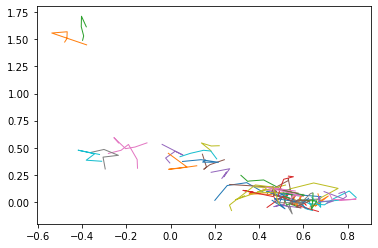

In [9]:
for k in range(0,n):
    
    plt.rc('lines', linewidth=1)
    
    for j in range(0,1):
    
        plt.plot(trajsd[k,-5:,j,0], trajsd[k,-5:,j,1])
    
plt.scatter(.6, 0., c = 'r', marker='x')

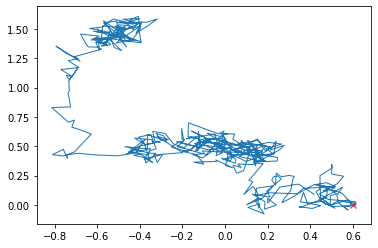

In [10]:
k = 0

plt.rc('lines', linewidth=1)

for j in range(0,1):

    plt.plot(trajsd[k,:,j,0], trajsd[k,:,j,1])
    
plt.scatter(.6, 0., c = 'r', marker='x')

100%|██████████| 500/500 [00:02<00:00, 185.67it/s]


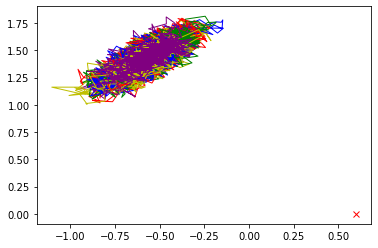

In [11]:
from matplotlib import pyplot as plt

dyn = Langevin_Dyn(**args)

initial_state2 = initial_state.view(1, 1, -1).repeat(n,1,1)
trajs, time, increments, A, B = dyn.Dyn_run(
    initial_state2
)
trajs = trajs.detach().numpy()

for k in range(0,n):
    default_cycler = (cycler(color=['r', 'g', 'b', 'y', 'purple']))

    plt.rc('lines', linewidth=1)
    plt.rc('axes', prop_cycle=default_cycler)
    for j in range(0,1):
        plt.plot(trajs[k,:,j,0], trajs[k,:,j,1])

plt.scatter(.6, 0., c = 'r', marker='x')

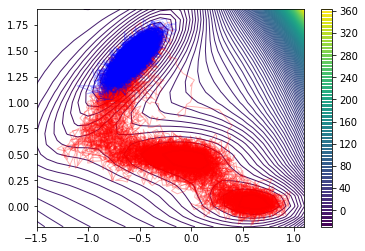

In [12]:
def potential(x):
    c_0 = torch.tensor([-2, -2, -2, -2, -2], device = device).view(1,initial_state.size(0),-1).repeat(x.size(0), 1, 1)
    c_1 = torch.tensor([2, 2, 2, 2, 2], device = device).view(1,initial_state.size(0),-1).repeat(x.size(0), 1, 1)
    potential = (torch.exp(-((x/3).norm(dim = 2))**2)*((((x-c_0)**2).sum(dim = 2))*(((x-c_1)**2).sum(dim = 2)))).sum(dim = 1)
    potential.view(-1,1)
    return potential


def muller_potential(x, y):
    """Muller potential
    
    Parameters
    ----------
    x : {float, np.ndarray}
        X coordinate. Can be either a single number or an array. If you supply
        an array, x and y need to be the same shape.
    y : {float, np.ndarray}
        Y coordinate. Can be either a single number or an array. If you supply
        an array, x and y need to be the same shape.
    Returns
    -------
    potential : {float, np.ndarray}
        Potential energy. Will be the same shape as the inputs, x and y.
    
    Reference
    ---------
    Code adapted from https://cims.nyu.edu/~eve2/ztsMueller.m
    """
    
    aa = [-1, -1, -6.5, 0.7]
    bb = [0, 0, 11, 0.6]
    cc = [-10, -10, -6.5, 0.7]
    AA = [-200, -100, -170, 15]
    XX = [1, 0, -0.5, -1]
    YY = [0, 0.5, 1.5, 1]
    
    
    # use symbolic algebra if you supply symbolic quantities
    exp = np.exp
    
    value = 0
    for j in range(0, 4):
        value += AA[j] * exp(aa[j] * (x - XX[j])**2 + \
            bb[j] * (x - XX[j]) * (y - YY[j]) + cc[j] * (y - YY[j])**2)
    return value


def Mueller_Potential(x):
    #form A*exp(a*(x-xo)^2 + b*(x-xo)*(y-yo) + c*(y-yo)^2)
    A = [-200., -100., -170, 15]
    a = [-1.,-1.,-6.5,0.7]
    b = [0.,0.,11.,0.6]
    c = [-10.,-10.,-6.5,0.7]
    xo = [1., 0., -0.5, -1.]
    yo = [0., 0.5, 1.5, 1]
    energy = torch.zeros(x.size(0), 1)
    xs = x[:,:,0]
    ys = x[:,:,1]
    for i in range(0,4):
        ref = torch.tensor([xo[i],yo[i]])
        delta = x-ref
        potential = A[i]*torch.exp(a[i]*((delta[:, :, 0]**2)) + b[i]*delta[:,:,0]*delta[:,:,1] + c[i]*(delta[:, :, 1]**2))
        potential = potential.sum(dim = 1).view(-1, 1)
        energy+=potential
    return 0.1*energy

probs = []

grid = 1.5
step = 0.1

for i in np.arange(-1.5,1.2, step):
    tmp = []
    for j in np.arange(-.2, 2, step):
        x = torch.tensor([[i,j],
                          [i,j],
                            ], device = device)
        x = x.view(1, x.size(0), -1)
        prob = Mueller_Potential(x).item()
        tmp.append(prob)
    probs.append(tmp)
x = np.arange(-1.5,1.2, step)
y = np.arange(-.2, 2, step)
plt.clf()
plt.contour(x, y, np.array(probs).T, 180)
plt.colorbar()
# for k in range(0,100):
#     default_cycler = (cycler(color=['r', 'g', 'b', 'y', 'purple']))

#     plt.rc('lines', linewidth=1)
#     plt.rc('axes', prop_cycle=default_cycler)
#     plt.plot(trajsd[k,:,0,0], trajsd[k,:,4,0], c = 'r')
#     plt.plot(trajs[k,:,0,0], trajs[k,:,4,0], c = 'black')
# # xo = [1., 0., -0.5, -1.]
# yo = [0., 0.5, 1.5, 1]
# for i in range(0,4):
#     plt.scatter(xo[i], yo[i], c = 'r')

plt.scatter(-0.6, 1.5, c = 'r', marker='x')
plt.scatter(.6,0., c = 'r', marker='x')

for k in range(0,n):
    default_cycler = (cycler(color=['r', 'g', 'b', 'y', 'purple']))

    plt.rc('lines', linewidth=1)
    plt.rc('axes', prop_cycle=default_cycler)
    for j in range(0,1):
        plt.plot(trajsd[k,:,j,0], trajsd[k,:,j,1], c= 'r', alpha = .3)


for k in range(0,n):
    default_cycler = (cycler(color=['r', 'g', 'b', 'y', 'purple']))

    plt.rc('lines', linewidth=1)
    plt.rc('axes', prop_cycle=default_cycler)
    for j in range(0,1):
        plt.plot(trajs[k,:,j,0], trajs[k,:,j,1], c= 'b', alpha = .3)


tensor(0.9999)
0.5042


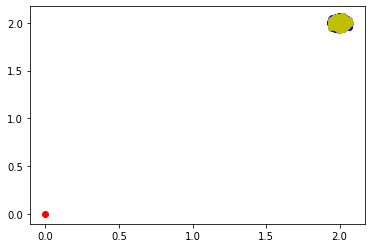

In [626]:
d = 3000

r = torch.randn(10000,d)/(d**0.5)
print(r.norm(dim = 1).mean())
#r = r/(r.norm(dim = 1).view(-1,1))
a = 2*torch.ones(d) + r
b = a[r.norm(dim = 1)<1]
print(len(b)/len(a))
plt.scatter(0,0)
plt.scatter(2,2)
plt.scatter(a[:,0].numpy(), a[:,1].numpy())
plt.scatter(b[:,0].numpy(), b[:,1].numpy())

In [49]:
trjs = torch.load('./data/data_val/trajs.pt')

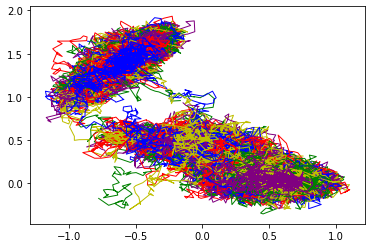

In [53]:

for i in range(0,1000):
    plt.plot(trjs[i, :, 0, 0].numpy(), trjs[i, :, 0, 1].numpy())

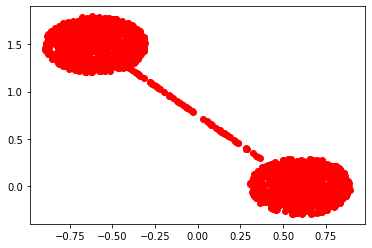

In [51]:
plt.scatter(trjs[:, 0, 0, 0].numpy(), trjs[:, 0, 0, 1].numpy())

In [113]:
import torch
import numpy as np

class Boundary_functions():
    """
    a set of functions to approximate the indicator function to different degrees
    """
    def __init__(self,
    reference, 
    tolerance, 
    slope, 
    mask,
    keyword = 'Indicator'
    ) -> None:

        self.reference = reference
        self.tolerance = tolerance
        self.slope = slope
        self.mask = mask
        self.keyword = keyword
            
    def Sigmoid(self, state):
        """
        Implementation of sigmoig function, if slope is too small gives nan gradients
        """
        x = torch.norm(self.mask*(state - self.reference),  dim = -1)
        y = (x - self.tolerance)/self.slope
        return torch.exp(-y)/(torch.exp(-y)+1)

    def Indicator_function(self, state):
        """
        Implementation of actual indicator function, to be used asking gradients to be zero (non differentiable on a zero measure set)
        """
        x = torch.norm(self.mask*(state - self.reference),  dim = 2)
        y = x - self.tolerance
        where_0 = y>0
        where_1 = y<=0
        y[where_0] = 0.*y[where_0] 
        y[where_1] = y[where_1]/y[where_1] 
        y = y.prod(dim = 1).view(-1,1)
        return y

    def Bump_function(self, state):
        """
        Implementation of Bump function, sort of works in all cases
        """
        x = torch.norm(self.mask.to(state.device)*(state - self.reference.to(state.device)),  dim = 2)/self.tolerance
        func = torch.exp(self.slope)*torch.exp(-self.slope/(1-x**2))
        mask = torch.ones_like(func).to(state.device)
        mask[x**2>1] = 0.
        func = func*mask
        print(func)
        func = func.prod(dim = 1)
        func = func.view(-1,1)
        
        return func
    
    def Function(self, state):

        if self.keyword == 'Indicator':
            return self.Indicator_function(state)

        if self.keyword == 'Bump':
            return self.Bump_function(state)

        if self.keyword == 'Sigmoid':
            return self.Sigmoid(state)

In [114]:
#from Boundary_Conditions import Boundary_functions

boundary_args = {
    'reference' : final_state,
    'tolerance' : .05,
    'slope' : .005,
    'mask' : mask,
    'keyword': 'Sigmoid' #alternatives 'Bump', 'Sigmoid', 'Indicator'
}

Func = Boundary_functions(**boundary_args)

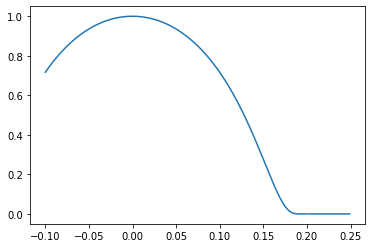

In [31]:
def bump(x, tolerance, slope):
    x = x/tolerance
    func = (x)**2
    func = 1-func
    func = -slope/func
    func = torch.exp(func + slope)
    func[(x)**2>=1] = 0.*func[(x)**2>=1]
    func = func.prod(dim = 1)
    func = func.view(-1,1)
    return func

plt.plot(torch.arange(-0.1, 0.25, .001).numpy(), bump(torch.arange(-0.1, 0.25, .001).view(-1,1), .2, 1).numpy())


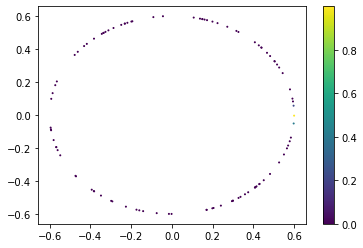

In [217]:
ref = boundary_args['reference'].view(1, 1, 2).repeat(10000, 1, 1)
ref = ref + boundary_args['tolerance']*(torch.randn_like(ref))
r = torch.randn(100,2)
ref = 3*boundary_args['tolerance']*r/r.norm(dim = 1).view(-1,1)
c = Func.Function(ref)
plt.scatter(ref[:,0].numpy(), ref[:,1].numpy(), c = c.numpy(), s = 1)
plt.colorbar()


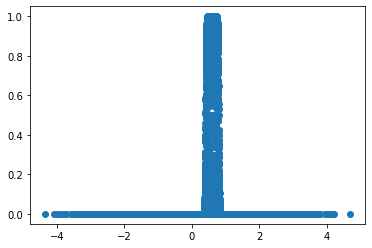

In [15]:
plt.scatter(a[:,:,0].numpy(), c.numpy())

In [27]:

data = torch.load('./data/data_val/trajs.pt')
torch.isnan(data).int().sum()

tensor(0)

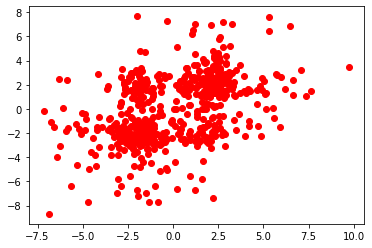

In [23]:
from matplotlib import pyplot as plt
plt.scatter(data[:,-1,0,0], data[:,-1,4,0])

In [1]:
from Data_Handler import Data_Handler
import torch
from Utilities import Create_uniform_initial

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'



temperature = 10.
box_size = 3
pow_2 = 14

initial_state = torch.tensor([[2.,0.],
                                [2.,0.],
                                [2.,0.],
                                [2.,0.],
                                [2.,0.],
                              ], device = device)

final_state = torch.tensor([[-2.,0.],
                            [-2.,0.],
                            [-2.,0.],
                            [-2.,0.],
                            [-2.,0.],
                            ], device = device)

def potential(x):
    c_0 = torch.tensor([-2, -2, -2, -2, -2], device = device).view(1,initial_state.size(0),-1).repeat(x.size(0), 1, 1)
    c_1 = torch.tensor([2, 2, 2, 2, 2], device = device).view(1,initial_state.size(0),-1).repeat(x.size(0), 1, 1)
    potential = (torch.exp(-((x/3).norm(dim = 2))**2)*((((x-c_0)**2).sum(dim = 2))*(((x-c_1)**2).sum(dim = 2)))).sum(dim = 1)
    potential.view(-1,1)
    return potential

initial_conds = Create_uniform_initial(
    pow_2, 
    initial_state, 
    final_state, 
    box_size, 
    temperature, 
    device = device
    )

In [48]:
torch.load('./data/data_test/trajs.pt').size()

torch.Size([39322, 101, 5, 2])

In [1]:
import torch
from torchani.utils import _get_derivatives_not_none as derivative
from torch.autograd import Variable

In [3]:
x = torch.randn(10, 5, 3, 2)

In [4]:
x = Variable(x, requires_grad = True)
y = (x**2).sum(dim = 3).sum(dim = 2)
z = derivative(x, y, retain_graph = True, create_graph = True).view(-1,2)
#h = derivative(x, z, retain_graph = True, create_graph = True)

In [5]:
from torch.autograd.functional import hessian
def func(x):
    return (x**2).sum(dim = 3).sum(dim = 2)
h = hessian(func, x)

RuntimeError: The Tensor returned by the function given to hessian should contain a single element

In [193]:
from torchani.utils import hessian
h = hessian(x, y)

In [188]:
h.size()

torch.Size([10, 30, 30])

In [72]:
#from functorch import vmap, vjp
compute_batch_hessian = torch.vmap(hessian, in_dims=(None, None, 0))

batch_hess = compute_batch_hessian(func, x)
batch_hess.shape

AttributeError: module 'torch' has no attribute 'vmap'

In [10]:
import torch
print(torch.__version__)

1.10.0+cu102


In [1]:
from Data_Handler import Data_Handler
data = Data_Handler(
    device = 'cpu'
)
data = data.load_datas_from_files()

In [15]:
data['val_dataset']

In [31]:
from Potentials import Mueller_Potential

x = torch.randn(100,3,2)

Mueller_Potential(x)

tensor([[ 1.0169e+03],
        [ 7.5334e+02],
        [ 3.2232e+03],
        [ 1.5938e+03],
        [ 1.3451e+03],
        [ 5.5631e+03],
        [ 1.7220e+03],
        [ 1.5599e+05],
        [ 1.1226e+03],
        [-7.5457e+01],
        [-6.3335e+01],
        [ 5.0202e+01],
        [ 1.4015e+03],
        [-1.4249e+01],
        [ 6.5413e+03],
        [ 2.9439e+04],
        [ 1.0083e+03],
        [ 1.3204e+02],
        [ 3.4562e+02],
        [ 6.6061e+02],
        [ 3.0657e+02],
        [ 1.3702e+02],
        [ 6.2399e+02],
        [ 1.7430e+01],
        [ 3.2627e+02],
        [ 7.2946e+02],
        [ 6.7924e+01],
        [ 4.8245e+02],
        [ 6.7519e+02],
        [ 1.1884e+06],
        [-1.2728e+00],
        [ 7.7213e+02],
        [ 2.8246e+02],
        [ 1.0381e+04],
        [ 5.7045e+02],
        [ 1.6578e+02],
        [ 1.1765e+06],
        [ 1.9524e+02],
        [-5.1520e+01],
        [ 2.9499e+03],
        [ 2.5779e+03],
        [ 1.3385e+03],
        [ 1.3902e+03],
        [ 2

In [32]:

def Mueller_Potential(x):
    #form A*exp(a*(x-xo)^2 + b*(x-xo)*(y-yo) + c*(y-yo)^2)
    A = [-200., -100., -170, 15]
    a = [-1.,-1.,-6.5,0.7]
    b = [0.,0.,11.,0.6]
    c = [-10.,-10.,-6.5,0.7]
    xo = [1., 0., -0.5, -1.]
    yo = [0., 0.5, 1.5, 1]
    energy = torch.zeros(x.size(0), 1)
    for i in range(0,4):
        ref = torch.tensor([xo[i],yo[i]])
        delta = x-ref
        potential = A[i]*torch.exp(a[i]*(delta[:, :, 0]**2) + b[i]*delta[:,:,0]*delta[:,:,1] + c[i]*(delta[:, :, 1]**2))
        potential = potential.sum(dim = 1).view(-1, 1)
        energy+=potential
    return energy

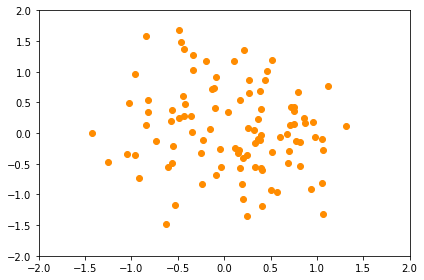

In [95]:
for t in range(0,10):
    a = ((t*(t+1)*0.5*1e-2)**0.5)*torch.randn(100, 2)
    plt.clf()
    plt.scatter(a[:,0], a[:,1], c='darkorange')
    plt.xlim(-2,2)
    plt.ylim(-2,2)
    plt.tight_layout()
    plt.savefig('./pres/{}.png'.format(t))

In [55]:
hidden_layers = 4
step = 2/hidden_layers
coefficients = np.arange(1*step, 2+1*step, step)
coefficients

array([0.5, 1. , 1.5, 2. ])

In [58]:
for c in np.flip(coefficients):
    print(int(c*64))

128
96
64
32
